# Task 2

In [1]:
#importing libraries
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torch.utils.data.dataloader as dataloader
from torchvision import datasets
import torchvision.models as models
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
#Define transformations for training and testing data
transform_train = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
transform_test = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),     
            ])

In [3]:
#Load files from dataset and load to dataset
filepath='.'
filedir=os.path.join(os.getcwd(),filepath,'Landscape Classification/Landscape Classification')
batch_size=16


for i in os.listdir(filedir):
    if(i=='Training Data'):
        train_dataset=datasets.ImageFolder(
            root=os.path.join(filedir,i),
            transform=transform_train
    )
    elif(i=='Testing Data'):
        test_dataset=datasets.ImageFolder(
            root=os.path.join(filedir,i),
            transform=transform_test
    )
    elif(i=='Validation Data'):
        valid_dataset=datasets.ImageFolder(
            root=os.path.join(filedir,i),
            transform=transform_test
    )

#Load the dataset into Dataloader
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size,shuffle=True)

# Base Model

In [4]:
#Define hyperparameters for base model

#number of filters for CNN
D1=32
D2=64
D3=128

#number of neurons for ANN
A1=512
A2=256
num_classes=5

#images are 224x224, so number of pixels are 224.
input_pix=224

#divide number of learnable parameters by 2 for each maxpool layer
#total number of neurons for the input for ANN = (224/2/2/2)^2 * D3 = 100352
#convolutional layers do not reduce the number of parameters as they are zero padded.
num_neurons=int(np.floor(np.floor(np.floor(input_pix/2)/2)/2)**2*D3)
input=3
class my_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(input, D1, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(D1, D2, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(D2, D3, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            
            
            nn.Linear(num_neurons,A1),
            nn.ReLU(),
            nn.Linear(A1, A2),
            nn.ReLU(),
            nn.Linear(A2,num_classes)
        )
    
    def forward(self, xb):
        return self.network(xb)

# Set Hyperparameters

In [5]:
#use cuda if available
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#Hyperparameters
lr = 1e-3
epochs = 15
opt=torch.optim.Adam
model=my_nn().to(device)

cuda


In [6]:
def train(model,train_loader,epochs,lr,opt,loss_func): #training function for model
    model.train() # set the model to training mode
    losslog=[]
    optimizer=opt
    for _,(x,y) in enumerate(train_loader): #load the train loader in batches
        batch_x=x.to(device) 
        ypred=model(batch_x)
        
        #calculate loss of ypred and ytrue
        loss=loss_func(ypred,y.to(device))
        losslog.append(loss.item())
        
        #set gradient to 0
        optimizer.zero_grad()
        
        #commence backpass
        loss.backward()
        
        #update step
        optimizer.step()
        
    return losslog

def evaluate(model,test_loader): #evaluation function for model
    model.eval() #set model to evaluation mode
    total_true = 0 #initialise accuracy as 0
        
    with torch.no_grad(): #ensure there is no gradient in the model
        for _, (x, y) in enumerate(test_loader):
            batch_x = model(x.to(device))
            total_true += (batch_x.argmax(1) == y.to(device)).sum().item() #find the total amount of correct predictions
            
    #return the accuracy   
    return total_true / len(test_loader.dataset)
            

def fit(model,train_loader,test_loader,val_loader,epochs,optimizer,lr=1e-3,loss_func=F.cross_entropy): #fit the model to the datasets
    
    #define variables
    train_acc_log=[]
    test_acc_log=[]
    valid_acc_log=[]

    opt=optimizer(model.parameters(),lr)
    for iter in range(epochs):
        #training step
        train_log=train(model,train_loader,epochs,lr,opt,loss_func)
            
        #evaluation step
        train_acc=evaluate(model,train_loader)
        test_acc=evaluate(model,test_loader)
        valid_acc=evaluate(model,valid_loader)
        print("Epoch [{}], train acc: {:.2f}, test acc: {:.2f}, val acc: {:.2f}".format(iter, train_acc, test_acc, valid_acc))
        
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        valid_acc_log.append(valid_acc)
    
    
    print('Training Complete')
    return train_acc_log,test_acc_log,valid_acc_log, train_log



In [8]:
train_acc_log,test_acc_log,valid_acc_log,train_log=fit(model,train_loader,test_loader,valid_loader,epochs,opt)

Epoch [0], train acc: 0.69, test acc: 0.69, val acc: 0.65
Epoch [1], train acc: 0.78, test acc: 0.74, val acc: 0.70
Epoch [2], train acc: 0.80, test acc: 0.74, val acc: 0.68
Epoch [3], train acc: 0.91, test acc: 0.79, val acc: 0.71
Epoch [4], train acc: 0.94, test acc: 0.79, val acc: 0.69
Epoch [5], train acc: 0.97, test acc: 0.78, val acc: 0.69
Epoch [6], train acc: 0.99, test acc: 0.79, val acc: 0.66
Epoch [7], train acc: 0.99, test acc: 0.77, val acc: 0.67
Epoch [8], train acc: 0.98, test acc: 0.78, val acc: 0.68
Epoch [9], train acc: 0.98, test acc: 0.80, val acc: 0.69
Epoch [10], train acc: 0.99, test acc: 0.78, val acc: 0.71
Epoch [11], train acc: 0.99, test acc: 0.78, val acc: 0.68
Epoch [12], train acc: 0.99, test acc: 0.80, val acc: 0.69
Epoch [13], train acc: 0.99, test acc: 0.77, val acc: 0.68
Epoch [14], train acc: 0.99, test acc: 0.78, val acc: 0.70
Training Complete


In [ ]:
#Plotting accuracies for base model
plt.plot(range(15),train_acc_log)
plt.title('Training Accuracy over Epoch ')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.show()
plt.plot(range(15),test_acc_log)
plt.title('Testing Accuracy over Epoch ')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.show()
plt.plot(range(15),valid_acc_log)
plt.title('Valid Accuracy over Epoch ')
plt.xlabel('Epochs')
plt.ylabel('Valid Accuracy')
plt.show()

# Transfer Learning (Vgg16)

### Utilise VGG16 from [link](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py)

In [7]:
transfer_vgg16 = models.vgg16(weights='DEFAULT').to(device) #Initialise VGG16
for layers in transfer_vgg16.parameters():
    layers.requires_grad=False #Freeze layers

#Recreate the original classifier, but set the output layer to 5 neurons
dropout=0.2
num_classes=5
transfer_vgg16.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(1000,num_classes) #modifying the last layer to fit only 5 classes
        ).to(device)
        

In [8]:
#retrain the last layer
train_acc_log_vgg,test_acc_log_vgg,valid_acc_log_vgg,train_log_vgg=fit(transfer_vgg16,train_loader,test_loader,valid_loader,epochs,opt)

Epoch [0], train acc: 0.91, test acc: 0.84, val acc: 0.76
Epoch [1], train acc: 0.93, test acc: 0.85, val acc: 0.80
Epoch [2], train acc: 0.96, test acc: 0.87, val acc: 0.80
Epoch [3], train acc: 0.98, test acc: 0.85, val acc: 0.77
Epoch [4], train acc: 0.98, test acc: 0.87, val acc: 0.79
Epoch [5], train acc: 0.98, test acc: 0.87, val acc: 0.74
Epoch [6], train acc: 0.98, test acc: 0.86, val acc: 0.78
Epoch [7], train acc: 0.98, test acc: 0.85, val acc: 0.74
Epoch [8], train acc: 0.98, test acc: 0.85, val acc: 0.75
Epoch [9], train acc: 0.99, test acc: 0.87, val acc: 0.76
Epoch [10], train acc: 0.99, test acc: 0.86, val acc: 0.77
Epoch [11], train acc: 0.99, test acc: 0.86, val acc: 0.77
Epoch [12], train acc: 1.00, test acc: 0.87, val acc: 0.78
Epoch [13], train acc: 1.00, test acc: 0.87, val acc: 0.78
Epoch [14], train acc: 0.99, test acc: 0.87, val acc: 0.76
Training Complete


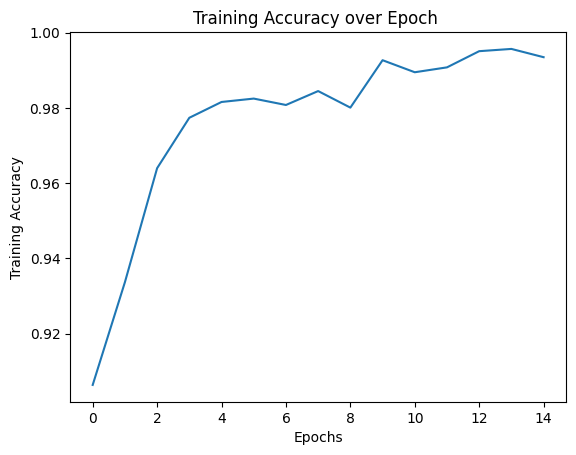

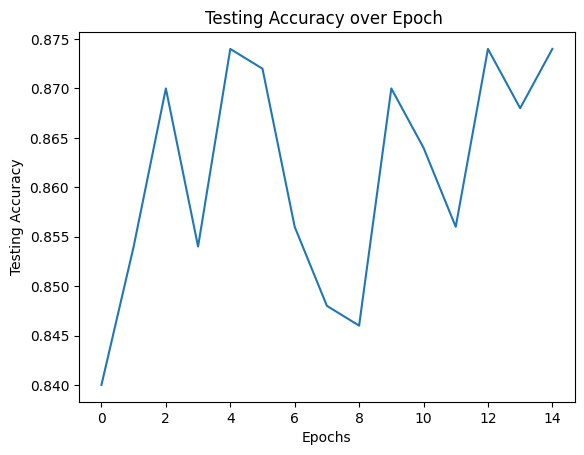

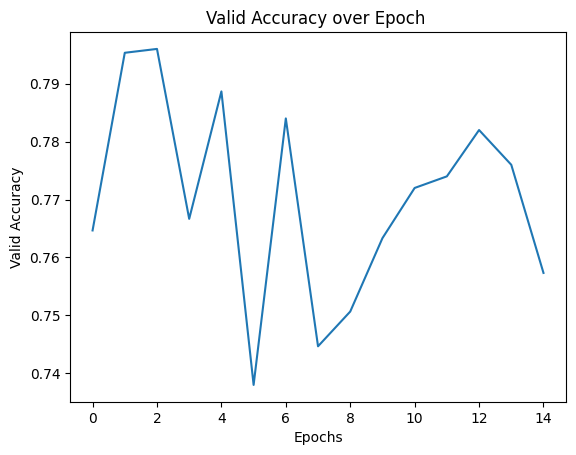

In [10]:
#plotting for VGG16
plt.plot(range(15),train_acc_log_vgg)
plt.title('Training Accuracy over Epoch ')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.show()
plt.plot(range(15),test_acc_log_vgg)
plt.title('Testing Accuracy over Epoch ')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.show()
plt.plot(range(15),valid_acc_log_vgg)
plt.title('Valid Accuracy over Epoch ')
plt.xlabel('Epochs')
plt.ylabel('Valid Accuracy')
plt.show()

# Transfer Learning (AlexNet)

### AlexNet from [Link](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py)

In [9]:
transfer_alexnet = models.alexnet(weights='DEFAULT').to(device)
for layers in transfer_alexnet.parameters():
    layers.requires_grad=False #Freeze layers

dropout=0.2
num_classes=5
transfer_alexnet.classifier= nn.Sequential( #Rebuilding the classifier to be the same as Alex Net but an added Dense layer for the number of classes for this dataset (5)
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(1000,num_classes) #modifyiing only the last layer
        ).to(device)
        

In [10]:
#retrain the last layer
train_acc_log_alex,test_acc_log_alex,valid_acc_log_alex,train_log_alex=fit(transfer_alexnet,train_loader,test_loader,valid_loader,epochs,opt)

Epoch [0], train acc: 0.84, test acc: 0.82, val acc: 0.73
Epoch [1], train acc: 0.91, test acc: 0.84, val acc: 0.77
Epoch [2], train acc: 0.90, test acc: 0.82, val acc: 0.76
Epoch [3], train acc: 0.95, test acc: 0.85, val acc: 0.78
Epoch [4], train acc: 0.94, test acc: 0.85, val acc: 0.77
Epoch [5], train acc: 0.96, test acc: 0.86, val acc: 0.78
Epoch [6], train acc: 0.97, test acc: 0.85, val acc: 0.77
Epoch [7], train acc: 0.96, test acc: 0.84, val acc: 0.77
Epoch [8], train acc: 0.98, test acc: 0.84, val acc: 0.77
Epoch [9], train acc: 0.98, test acc: 0.83, val acc: 0.76
Epoch [10], train acc: 0.99, test acc: 0.85, val acc: 0.78
Epoch [11], train acc: 0.98, test acc: 0.86, val acc: 0.79
Epoch [12], train acc: 0.99, test acc: 0.87, val acc: 0.77
Epoch [13], train acc: 0.99, test acc: 0.86, val acc: 0.77
Epoch [14], train acc: 0.99, test acc: 0.88, val acc: 0.79
Training Complete


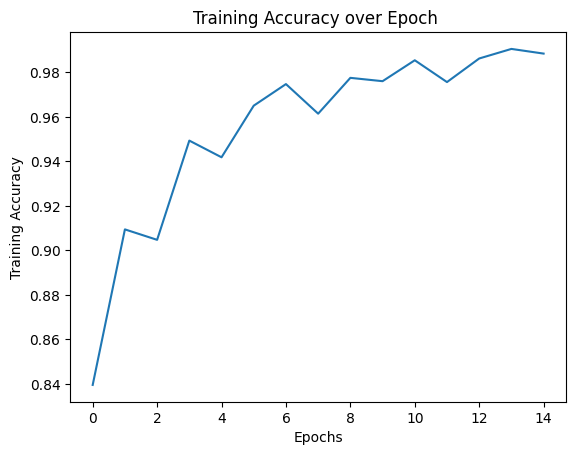

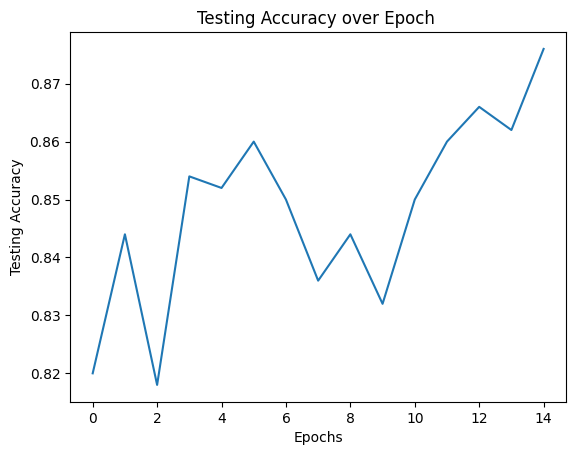

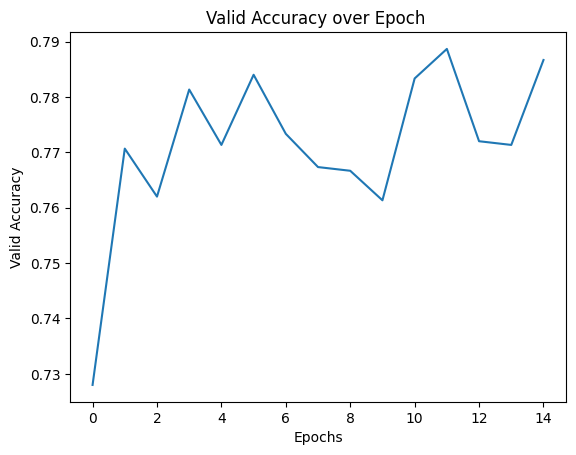

In [11]:
#plotting for AlexNet
plt.plot(range(15),train_acc_log_alex)
plt.title('Training Accuracy over Epoch ')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.show()
plt.plot(range(15),test_acc_log_alex)
plt.title('Testing Accuracy over Epoch ')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.show()
plt.plot(range(15),valid_acc_log_alex)
plt.title('Valid Accuracy over Epoch ')
plt.xlabel('Epochs')
plt.ylabel('Valid Accuracy')
plt.show()